In [1]:
import numpy as np
import pandas as pd
import plot_util
import seaborn as sns

from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
from scipy.stats import gmean, gstd

# Estimating proteome NOSC using coding sequences alone

Some previous work, mostly from Jeff Dick and co-authors, investigates the relationships between environmental chemistry (redox) and the $Z_C$ values of protein coding sequences in prokaryotic genomes. Here I ask how different genomic values are from those inferred from high-quality proteomics datasets to ascertain if there is additional chemical information in the expression data. 

In *E. coli*, 1000 proteins account for more than 95% of total protein C. Therefore, I repeatedly sample 1000 proteins from the coding sequence and ask what their typical $Z_C$ value is. This gives an unweighted estimate of the range of $Z_C$ values accomodated by the genome. Since gene expression spans 5-6 orders and is roughly log-normally distributed, I also sample 1000 proteins from a lognormal spanning 5 orders and calculate $Z_C$ values from those samples. This latter approach asks what range of protein $Z_{C,P}$ is plausible for expression datasets.

# References 

* J. M. Dick, G. M. Boyer, P. A. Canovas 3rd, E. L. Shock, Using thermodynamics to obtain geochemical information from genomes. Geobiology (2022) https:/doi.org/10.1111/gbi.12532.

* J. M. Dick, Average oxidation state of carbon in proteins. J. R. Soc. Interface 11, 20131095 (2014).

In [2]:
# First estimate a log-normal distribution for the protein abundances
# Unified file of the protein-level measurements.
all_expression_data = pd.read_csv('../data/proteomes/all_protein_measurements.csv')

# Grab expression data from Schmidt chemostat experiments
mask = np.logical_and(all_expression_data.dataset == 'schmidt_2016',
                      all_expression_data.condition.str.startswith('chemo'))
schmidt_chemostat = all_expression_data[mask]

/opt/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


chemostat_u0.12: mu=5.02, sigma=2.30
chemostat_u0.2: mu=5.10, sigma=2.31
chemostat_u0.35: mu=5.22, sigma=2.32
chemostat_u0.5: mu=5.36, sigma=2.33


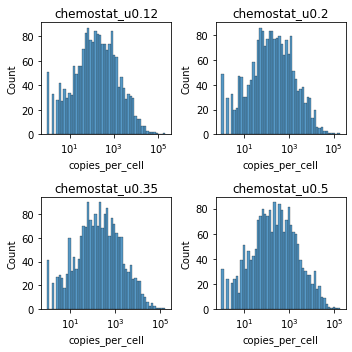

In [3]:
# Plot distributions of protein abundances --
# 1. Seems like log-normal is a good fit
# 2. sigma ≈ 2.3
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
flat_axs = axs.flatten()

for i, (idx, gdf) in enumerate(schmidt_chemostat.groupby('condition')):
    plt.sca(flat_axs[i])
    plt.xscale('log')
    mask = gdf.copies_per_cell > 0
    sns.histplot(data=gdf[mask], x='copies_per_cell', bins=50)

    # Fit the log-scaled data to a Gaussian
    vals = gdf[mask].copies_per_cell.values
    gm = GaussianMixture(n_components=1)
    gm.fit(np.log(vals).reshape(-1, 1))
    mu = gm.means_[0][0]
    sigma = np.sqrt(gm.covariances_[0][0][0])
    print(f'{idx}: mu={mu:.2f}, sigma={sigma:.2f}')
    flat_axs[i].set_title(idx)

plt.tight_layout()
plt.show()

In [4]:
# Load the reference proteomes with NOSC information
long_nosc_df = pd.read_csv('../data/genomes/all_ref_prot_NOSC.csv')
long_nosc_df.head()

,primary_accession,aa_seq,num_aas,NC,Ce,NOSC,mw_daltons,transmembrane_aas,transmembrane_Cs,fraction_transmembrane,...,COG_IDs,KEGG_IDs,isoform_accessions,KEGG_path_IDs,KEGG_pathways,eC_ratio,organism,b_number,primary_COG_category,secondary_COG_category
0,A5A605,MRLHVKLKEFLSMFFMAILFFPAFNASLFFTGVKPLYSIIKCSTEI...,159,862.0,-301.25,-0.349478,18118.0,60.0,345.0,0.377358,...,ENOG5031M8I,eco:b4586,NaN,NaN,NaN,4.349478,coli,b4586,NaN,NaN
1,P02929,MTLDLPRRFPWPTLLSVCIHGAVVAGLLYTSVHQVIELPAPAQPIS...,239,1173.0,-244.16,-0.208150,26094.0,31.0,159.0,0.129707,...,COG0810,"ecj:JW5195,eco:b1252",NaN,NaN,NaN,4.208150,coli,b1252,M,NaN
2,P05523,MPELPEVETSRRGIEPHLVGATILHAVVRNGRLRWPVSEEIYRLSD...,269,1358.0,-231.79,-0.170685,30290.0,0.0,0.0,0.000000,...,COG0266,"ecj:JW3610,eco:b3635",NaN,path:eco03410,Base excision repair - Escherichia coli K-12 M...,4.170685,coli,b3635,L,NaN
3,P06611,MSIVMQLQDVAESTRLGPLSGEVRAGEILHLVGPNGAGKSTLLARM...,249,1189.0,-157.82,-0.132733,27081.0,0.0,0.0,0.000000,...,COG4138,"ecj:JW1699,eco:b1709",NaN,path:eco02010,ABC transporters - Escherichia coli K-12 MG1655,4.132733,coli,b1709,H,NaN
4,P07109,MSENKLNVIDLHKRYGEHEVLKGVSLQANAGDVISIIGSSGSGKST...,257,1266.0,-201.82,-0.159415,28653.0,0.0,0.0,0.000000,...,COG4598,"ecj:JW2303,eco:b2306",NaN,path:eco02010,ABC transporters - Escherichia coli K-12 MG1655,4.159415,coli,b2306,E,NaN


In [5]:
# Monte Carlo sampling to estimate plausible range of proteome NOSC
eq_weight_estimates = dict(organism=[], NOSC=[], eC_ratio=[])
weighted_estimates = dict(organism=[], NOSC=[], eC_ratio=[])
# estimate a range on the coding sequence NOSC
cols2sum = 'NC,Ce'.split(',')
rows_mask = long_nosc_df[cols2sum].notnull().all(axis=1)


# For each organism, we sample 1000 genes across 5 orders of expression
# 1e5 times and record the NOSC of the samples. We also make an unweighted 
# estimate, but they should have the same mean. 
for gid, gdf in long_nosc_df.loc[rows_mask].groupby('organism'):
    print(gid)
    for _ in range(10000):
        # In E. coli, 1000 genes covers ≈99% of protein C atoms
        sample = gdf.sample(1000)
        s = sample[cols2sum].sum()
        
        sample_nosc = s.Ce / s.NC

        eq_weight_estimates['organism'].append(gid)
        eq_weight_estimates['NOSC'].append(sample_nosc)
        eq_weight_estimates['eC_ratio'].append(4 - sample_nosc)
        
        # Above we saw that expression data are approximately log-normal with sigma ≈ 2.3
        # So we will sample from log-normal with a std deviation of 2.5 orders
        # so that the samples span ≈5 orders of magnitude in expression like data
        expression = np.random.lognormal(size=1000, sigma=2.5)
        Ce_weighted = sample.Ce * expression
        NC_weighted = sample.NC * expression
        sample_nosc_weighted = Ce_weighted.sum() / NC_weighted.sum()
        
        weighted_estimates['organism'].append(gid)
        weighted_estimates['NOSC'].append(sample_nosc_weighted)
        weighted_estimates['eC_ratio'].append(4 - sample_nosc_weighted)
        
eq_weight_nosc_est_df = pd.DataFrame(eq_weight_estimates)
eq_weight_nosc_est_df.to_csv('../data/genomes/all_ref_prot_NOSC_unweighted_monte_carlo_samples.csv', index=False)
weighted_nosc_est_df = pd.DataFrame(weighted_estimates)
weighted_nosc_est_df.to_csv('../data/genomes/all_ref_prot_NOSC_weighted_monte_carlo_samples.csv', index=False)

PCC6803
coli
yeast


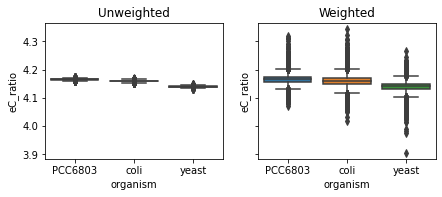

In [6]:
# Compare the weighted and unweighted samples
fig, axs = plt.subplots(ncols=2, figsize=(7,2.5), sharey=True)

plt.sca(axs[0])
sns.boxplot(data=eq_weight_nosc_est_df, x='organism', y='eC_ratio')
plt.title('Unweighted')

plt.sca(axs[1])
plt.title('Weighted')
sns.boxplot(data=weighted_nosc_est_df, x='organism', y='eC_ratio')

plt.show()